In [1]:
import os
#os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

os.environ['TF_USE_LEGACY_KERAS'] = '1';

In [2]:
input_default_json_conf_file='fcnn_emotion4_training_default.json';

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import datetime
import json

2024-07-24 12:10:38.395709: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-24 12:10:39.812366: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
import sys
sys.path.append('../library');

In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2024-07-24 12:10:41.608155: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-24 12:10:41.704362: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-24 12:10:41.704843: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [6]:
## Load json conf json file
fd = open(os.path.join('./',input_default_json_conf_file));
DATA = json.load(fd);
fd.close()

# Variable globales

In [7]:
## Seed for the random variables
seed_number=0;

## Dataset 
dataset_base_dir    = DATA['dataset_train_base_dir'];
dataset_labels_file = DATA['dataset_train_labels_file'];

dataset_base_test_dir    = DATA['dataset_test_base_dir'];
dataset_labels_test_file = DATA['dataset_test_labels_file'];

dataset_name        = DATA['dataset_name'];

## Training hyperparameters
EPOCAS     = DATA["epochs"];
BATCH_SIZE = DATA["batch_size"];


## Output
output_base_dir = DATA["output_base_dir"];

file_of_weight=''
subdir='enccls';
patience=max(10,int(EPOCAS/10));
NCOD=15;
ANGLE=60;

# Parametros de entrada

In [8]:
for n in range(len(sys.argv)):
    if sys.argv[n]=='--dataset-train-dir':
        dataset_base_dir=sys.argv[n+1];
    elif sys.argv[n]=='--dataset-train-file':
        dataset_labels_file=sys.argv[n+1];
    elif sys.argv[n]=='--dataset-test-dir':
        dataset_base_test_dir=sys.argv[n+1];
    elif sys.argv[n]=='--dataset-test-file':
        dataset_labels_test_file=sys.argv[n+1];
    elif sys.argv[n]=='--dataset-name':
        dataset_name=sys.argv[n+1];
    elif sys.argv[n]=='--epochs':
        EPOCAS=int(sys.argv[n+1]);
    elif sys.argv[n]=='--batch-size':
        BATCH_SIZE=int(sys.argv[n+1]);
    elif sys.argv[n]=='--ncod':
        NCOD=int(sys.argv[n+1]);
    elif sys.argv[n]=='--patience':
        patience=int(sys.argv[n+1]);
    elif sys.argv[n]=='--subdir':
        subdir=sys.argv[n+1];
    elif sys.argv[n]=='--weights-init':
        file_of_weight=sys.argv[n+1];
    elif sys.argv[n]=='--output-dir':
        output_base_dir=sys.argv[n+1];
        
print('        dataset_base_dir:',dataset_base_dir)
print('     dataset_labels_file:',dataset_labels_file)
print('   dataset_base_test_dir:',dataset_base_test_dir)
print('dataset_labels_test_file:',dataset_labels_test_file)
print('            dataset_name:',dataset_name)
print('                  EPOCAS:',EPOCAS)
print('              BATCH_SIZE:',BATCH_SIZE)
print('                    NCOD:',NCOD)
print('                patience:',patience)
print('                  subdir:',subdir)
print('          file_of_weight:',file_of_weight)
print('         output_base_dir:',output_base_dir)

        dataset_base_dir: /media/fernando/Expansion/DATASET/TESE/BER/BER2024/BER2024-SKELETON
     dataset_labels_file: train.csv
   dataset_base_test_dir: /media/fernando/Expansion/DATASET/TESE/BER/BER2024/BER2024-SKELETON
dataset_labels_test_file: test.csv
            dataset_name: ber2024-skel
                  EPOCAS: 40
              BATCH_SIZE: 1024
         output_base_dir: /media/fernando/Expansion/OUTPUTS/DOCTORADO2/fcnn_emotion4


# Set seed of random variables


In [9]:
np.random.seed(seed_number)
tf.keras.utils.set_random_seed(seed_number);

# Loading data of dataset

In [10]:
# Load filenames and labels
train_val_df = pd.read_csv(os.path.join(dataset_base_dir,dataset_labels_file));
#print(train_val_df)

# Setting labels
Y = train_val_df[['label']];
L=np.shape(Y)[0];

# Load test filenames and labels
test_df = pd.read_csv(os.path.join(dataset_base_test_dir,dataset_labels_test_file));

print('\n\ntest_df')
print(test_df)




test_df
              d0         d1        d2         d3         d4        d5  \
0      578.53033  230.53235  0.997254  584.17610  221.87859  0.972028   
1      920.09784  375.53006  0.972105  944.41710  346.81830  0.997568   
2      766.30960  252.15428  0.994588  777.61940  225.52296  0.991696   
3      710.24036  232.16788  0.993728  724.85980  201.97440  0.998824   
4      743.05970  192.98499  0.992488  765.76780  169.78462  0.989598   
...          ...        ...       ...        ...        ...       ...   
16674  439.34560  229.46915  0.991680  457.49250  200.63686  0.990643   
16675  831.20184  257.23987  0.993503  870.40430  225.87146  0.991977   
16676  675.22986  146.00938  0.998339  714.07970  129.44043  0.990368   
16677  365.72820  188.31245  0.993100  383.71097  165.13180  0.991528   
16678  820.39874  276.85623  0.992258  846.90924  255.66278  0.990174   

              d6          d7        d8          d9  ...  d42  d43  d44  d45  \
0      555.77313  209.135130  0.98

# Setting the cross-validation split


In [11]:
from sklearn.model_selection import train_test_split

training_df, validation_df = train_test_split(train_val_df, test_size=0.2,shuffle=True, stratify=Y)

print('\n\ntraining_df')
print(training_df);


print('\n\nvalidation_df')
print(validation_df)



training_df
               d0         d1        d2          d3         d4        d5  \
8982    960.05600  202.20062  0.994441   976.69696  189.05788  0.992597   
11571   734.76117  259.07974  0.993402   759.39734  234.89705  0.991606   
17123   652.60890  174.34769  0.992906   675.89560  160.28514  0.989038   
20066   556.48460  194.43310  0.998464   589.38180  167.67004  0.993131   
8822    429.19846  220.50840  0.992251   463.33950  198.33228  0.998347   
...           ...        ...       ...         ...        ...       ...   
7149    490.36950  226.31702  0.988921   496.08840  212.05159  0.986984   
20120  1056.60690  265.03806  0.990833  1076.93210  245.03746  0.986916   
14275   476.07532  332.64615  0.992961   495.98813  290.08920  0.993253   
5284    570.50950  168.71097  0.992591   592.79803  150.86066  0.990587   
7290    746.79913  177.09557  0.990950   764.65170  162.77843  0.989897   

               d6         d7        d8         d9  ...  d42  d43  d44  d45  \
8982   

# Data augmentation configuration

In [12]:
import SkeletonEmotion4Lib.DataAugmentation as sda
import SkeletonEmotion4Lib.lib_tools as slt

training_data_array   = slt.batch_normalize_coordinates(training_df.iloc[:,0:51].values)
validation_data_array = slt.batch_normalize_coordinates(validation_df.iloc[:,0:51].values)
test_data_array       = slt.batch_normalize_coordinates(test_df.iloc[:,0:51].values)

print('train:',training_data_array.shape)
print('val:',validation_data_array.shape)
print('test:',test_data_array.shape)

train_data_generator = sda.DataAugmentationEncDecGenerator(training_data_array, 
                                    batch_size=BATCH_SIZE, 
                                    augment_fn=lambda X: slt.batch_random_rotate_coordinates(X,angle=ANGLE),
                                    shuffle=True);

valid_data_generator = sda.DataAugmentationEncDecGenerator(validation_data_array, 
                                        batch_size=BATCH_SIZE, 
                                        augment_fn=None,
                                        shuffle=True);

test_data_generator = sda.DataAugmentationEncDecGenerator(   test_data_array, 
                                            batch_size=BATCH_SIZE, 
                                            augment_fn=None,
                                            shuffle=False);




train: (21594, 51)
val: (5399, 51)
test: (16679, 51)


# Creating output directory

In [13]:
output_dir = os.path.join(output_base_dir,dataset_name,'training_validation_holdout',subdir);

os.makedirs(output_base_dir,exist_ok = True);

os.makedirs(output_dir,exist_ok = True);

# Create new encoder-decoder model

In [14]:
import SkeletonEmotion4Lib.lib_model as mpp

model = mpp.create_model_encdec(load_weights=False,file_of_weight='',ncod=NCOD);

print('input_shape',model.input_shape)
print('output_shape',model.output_shape)
print('')

model.summary()

mpp.save_model_parameters(model, os.path.join(output_dir,'parameters_stats_endec.m'));


input_shape (None, 51)
output_shape (None, 51)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 15)                17128     
                                                                 
 sequential_1 (Sequential)   (None, 51)                17164     


2024-07-24 12:10:49.215335: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-24 12:10:49.215616: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-24 12:10:49.215820: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

                                                                 
Total params: 34292 (133.95 KB)
Trainable params: 34292 (133.95 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
# COMPILE NEW MODEL
model.compile(loss='mse',
              optimizer='adam',
              metrics=['RootMeanSquaredError'])

# CREATE CALLBACKS
best_model_encdec_file=os.path.join(output_dir,'model_encdec.h5');
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=best_model_encdec_file, 
                                                save_weights_only=True,
                                                monitor='val_loss', 
                                                save_best_only=True, 
                                                verbose=1);

# Definindo o callback EarlyStopping
early_stopping = tf.keras.callbacks.EarlyStopping(  monitor='val_loss', 
                                                    patience=patience,  
                                                    verbose=1, 
                                                    restore_best_weights=False);

log_dir = os.path.join(output_dir,"logs","fit",'encdec-'+datetime.datetime.now().strftime("%Y%m%d-%H%M%S"));
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [16]:
# FIT THE MODEL
history = model.fit(train_data_generator,
                    epochs=EPOCAS,
                    validation_data=valid_data_generator,
                    callbacks=[checkpoint,early_stopping,tensorboard_callback],
                    verbose=1
                   );

Epoch 1/40


I0000 00:00:1721833861.379215  366603 service.cc:145] XLA service 0x7c4f3420a0e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721833861.379275  366603 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce MX150, Compute Capability 6.1
2024-07-24 12:11:01.388194: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-24 12:11:01.415357: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906
I0000 00:00:1721833861.502162  366603 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


21/22 [===========================>..] - ETA: 0s - loss: 0.5960 - root_mean_squared_error: 0.7720
Epoch 1: val_loss improved from inf to 0.45017, saving model to /media/fernando/Expansion/OUTPUTS/DOCTORADO2/fcnn_emotion4/ber2024-skel/training_validation_holdout/model_encdec.h5
22/22 [==============================] - 14s 61ms/step - loss: 0.5911 - root_mean_squared_error: 0.7688 - val_loss: 0.4502 - val_root_mean_squared_error: 0.6709
Epoch 2/40
22/22 [==============================] - ETA: 0s - loss: 0.4034 - root_mean_squared_error: 0.6351
Epoch 2: val_loss improved from 0.45017 to 0.31469, saving model to /media/fernando/Expansion/OUTPUTS/DOCTORADO2/fcnn_emotion4/ber2024-skel/training_validation_holdout/model_encdec.h5
22/22 [==============================] - 1s 38ms/step - loss: 0.4034 - root_mean_squared_error: 0.6351 - val_loss: 0.3147 - val_root_mean_squared_error: 0.5610
Epoch 3/40
22/22 [==============================] - ETA: 0s - loss: 0.3501 - root_mean_squared_error: 0.5917

max_val_acc 0.6709461212158203


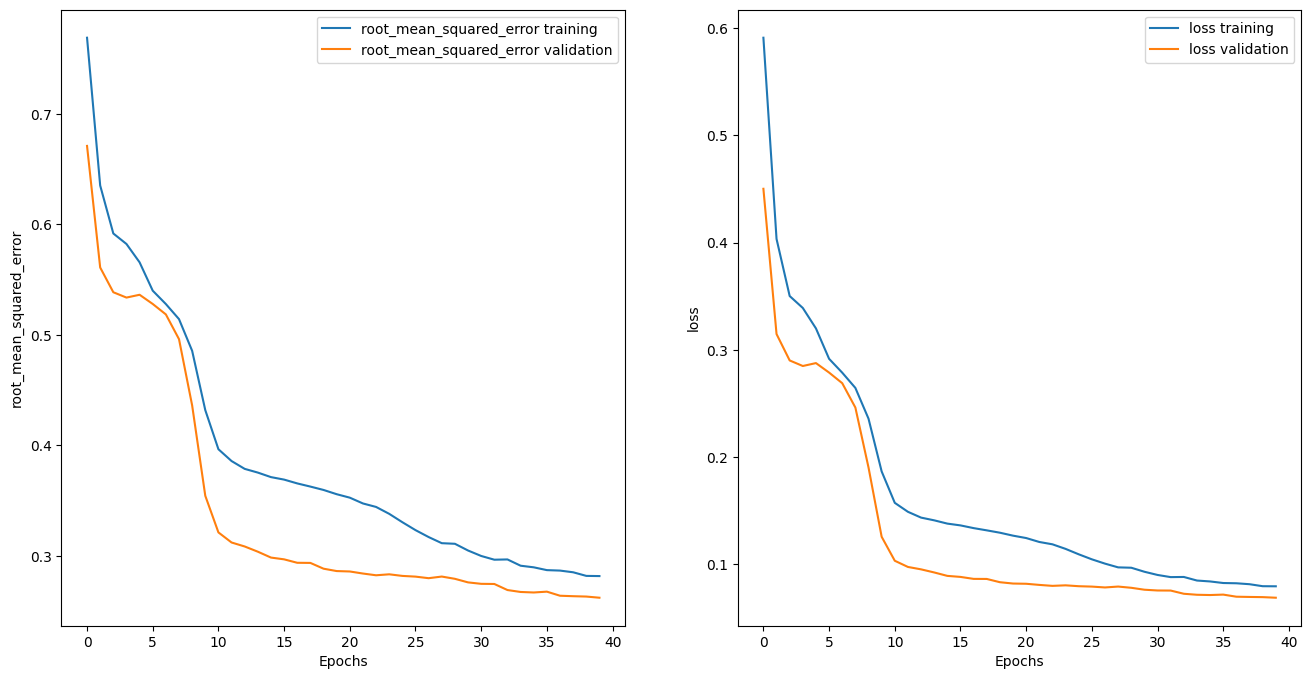

In [17]:
mpp.save_model_history(history,
                       os.path.join(output_dir,"historical_encdec.csv"),
                       show=False,
                       labels=['root_mean_squared_error','loss']);

In [18]:
model.load_weights(best_model_encdec_file); 


best_model_encoder_file=os.path.join(output_dir,'model_encoder.h5');
best_model_decoder_file=os.path.join(output_dir,'model_decoder.h5');

model.layers[0].save_weights(best_model_encoder_file);
model.layers[1].save_weights(best_model_decoder_file);

# Evaluate best encode-decoder model

In [19]:
# LOAD BEST MODEL to evaluate the performance of the model
model.load_weights(best_model_encdec_file);
data_results=dict();

# Evaluate training
results = model.evaluate(train_data_generator)
results = dict(zip(model.metrics_names,results))
print('training',results,"\n\n");
for key,value in results.items():
    data_results['train_'+key]=value;

# Evaluate validation
results = model.evaluate(valid_data_generator)
results = dict(zip(model.metrics_names,results))
print('validation',results,"\n\n");
for key,value in results.items():
    data_results['val_'+key]=value;

# Evaluate testing
results = model.evaluate(test_data_generator)
results = dict(zip(model.metrics_names,results))
print('testing',results,"\n\n");
for key,value in results.items():
    data_results['test_'+key]=value;

data_results['number_of_parameters']=mpp.get_model_parameters(model);

# final all json
with open(os.path.join(output_dir,"training_data_results_encdec.json"), 'w') as f:
    json.dump(data_results, f,indent=4);

tf.keras.backend.clear_session()


22/22 [==============================] - 1s 43ms/step - loss: 0.0788 - root_mean_squared_error: 0.2807
training {'loss': 0.07878986746072769, 'root_mean_squared_error': 0.2806953191757202} 


6/6 [==============================] - 0s 8ms/step - loss: 0.0688 - root_mean_squared_error: 0.2622
validation {'loss': 0.06877236068248749, 'root_mean_squared_error': 0.26224485039711} 


17/17 [==============================] - 0s 4ms/step - loss: 0.0685 - root_mean_squared_error: 0.2617
testing {'loss': 0.0684816911816597, 'root_mean_squared_error': 0.26169005036354065} 




# Dataset

In [20]:

training_dataset = sda.DataAugmentationClsGenerator(training_data_array, 
                                                    training_df.iloc[:,51].values,
                                                    batch_size=BATCH_SIZE, 
                                                    augment_fn=lambda X: slt.batch_random_rotate_coordinates(X,angle=ANGLE),
                                                    shuffle=True);

validation_dataset = sda.DataAugmentationClsGenerator(  validation_data_array, 
                                                        validation_df.iloc[:,51].values,
                                                        batch_size=BATCH_SIZE, 
                                                        augment_fn=None,
                                                        shuffle=True);

test_dataset = sda.DataAugmentationClsGenerator(test_data_array, 
                                                test_df.iloc[:,51].values,
                                                batch_size=BATCH_SIZE, 
                                                augment_fn=None,
                                                shuffle=False);

# Create new model

In [21]:

model = mpp.create_model_enccls(load_weights=False,
                                file_of_weight=best_model_encoder_file,
                                file_of_weight_full=False,
                                ncod=NCOD);

print('input_shape',model.input_shape)
print('output_shape',model.output_shape)
print('')

model.summary()

mpp.save_model_parameters(model, os.path.join(output_dir,'parameters_stats_enccls.m'));

Loading the weights in: /media/fernando/Expansion/OUTPUTS/DOCTORADO2/fcnn_emotion4/ber2024-skel/training_validation_holdout/model_encoder.h5
Loaded the weights in: /media/fernando/Expansion/OUTPUTS/DOCTORADO2/fcnn_emotion4/ber2024-skel/training_validation_holdout/model_encoder.h5
input_shape (None, 51)
output_shape (None, 4)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 15)                17128     
                                                                 
 dense_5 (Dense)             (None, 91)                1456      
                                                                 
 dense_6 (Dense)             (None, 31)                2852      
                                                                 
 dense_7 (Dense)             (None, 15)                480       
                                                        

In [22]:
# COMPILE NEW MODEL
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['categorical_accuracy'])

# CREATE CALLBACKS
best_model_file=os.path.join(output_dir,'model_enccls.h5');
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=best_model_file, 
                                                save_weights_only=True,
                                                monitor='val_loss', 
                                                save_best_only=True, 
                                                verbose=1);

# Definindo o callback EarlyStopping
early_stopping = tf.keras.callbacks.EarlyStopping(  monitor='val_loss', 
                                                    patience=patience,  
                                                    verbose=1, 
                                                    restore_best_weights=False);

log_dir = os.path.join(output_dir,"logs","fit",'enccls-'+datetime.datetime.now().strftime("%Y%m%d-%H%M%S"));
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [23]:
# FIT THE MODEL
history = model.fit(training_dataset,
                    epochs=EPOCAS,
                    validation_data=validation_dataset,
                    callbacks=[checkpoint,early_stopping,tensorboard_callback],
                    verbose=1
                   );

Epoch 1/40
21/22 [===========================>..] - ETA: 0s - loss: 1.3849 - categorical_accuracy: 0.2642
Epoch 1: val_loss improved from inf to 1.38188, saving model to /media/fernando/Expansion/OUTPUTS/DOCTORADO2/fcnn_emotion4/ber2024-skel/training_validation_holdout/model_cls.h5
22/22 [==============================] - 5s 92ms/step - loss: 1.3849 - categorical_accuracy: 0.2640 - val_loss: 1.3819 - val_categorical_accuracy: 0.2725
Epoch 2/40
21/22 [===========================>..] - ETA: 0s - loss: 1.3804 - categorical_accuracy: 0.2762
Epoch 2: val_loss improved from 1.38188 to 1.37802, saving model to /media/fernando/Expansion/OUTPUTS/DOCTORADO2/fcnn_emotion4/ber2024-skel/training_validation_holdout/model_cls.h5
22/22 [==============================] - 1s 51ms/step - loss: 1.3802 - categorical_accuracy: 0.2772 - val_loss: 1.3780 - val_categorical_accuracy: 0.2732
Epoch 3/40
21/22 [===========================>..] - ETA: 0s - loss: 1.3742 - categorical_accuracy: 0.3034
Epoch 3: val_los

max_val_acc 0.3852565288543701


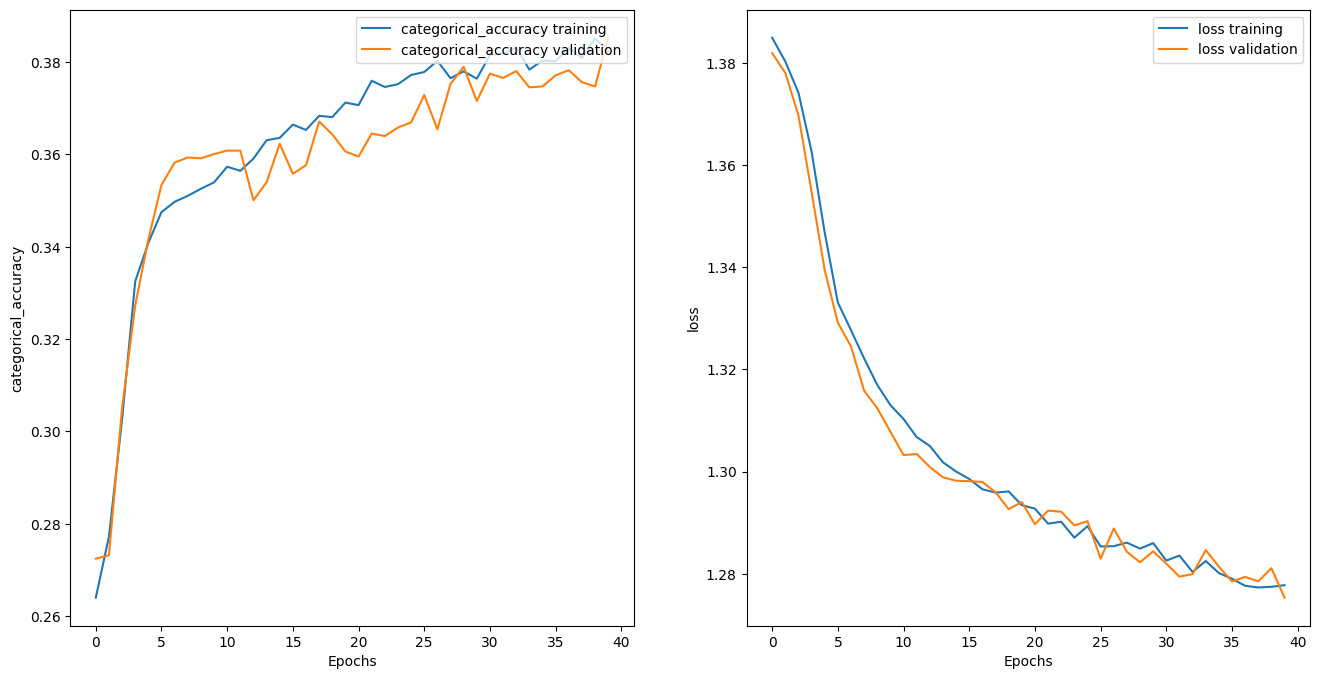

In [24]:
mpp.save_model_history(history,
                       os.path.join(output_dir,"historical_enccls.csv"),
                       show=False,
                       labels=['categorical_accuracy','loss']);

In [25]:
# LOAD BEST MODEL to evaluate the performance of the model
model.load_weights(best_model_file);
data_results=dict();

# Evaluate training
results = model.evaluate(training_dataset)
results = dict(zip(model.metrics_names,results))
print('training',results,"\n\n");
for key,value in results.items():
    data_results['train_'+key]=value;

# Evaluate validation
results = model.evaluate(validation_dataset)
results = dict(zip(model.metrics_names,results))
print('validation',results,"\n\n");
for key,value in results.items():
    data_results['val_'+key]=value;

# Evaluate testing
results = model.evaluate(test_dataset)
results = dict(zip(model.metrics_names,results))
print('testing',results,"\n\n");
for key,value in results.items():
    data_results['test_'+key]=value;

data_results['number_of_parameters']=mpp.get_model_parameters(model);

# final all json
with open(os.path.join(output_dir,"training_data_results_enccls.json"), 'w') as f:
    json.dump(data_results, f,indent=4);

tf.keras.backend.clear_session()

22/22 [==============================] - 1s 41ms/step - loss: 1.2768 - categorical_accuracy: 0.3858
training {'loss': 1.276790738105774, 'categorical_accuracy': 0.38584792613983154} 


6/6 [==============================] - 0s 5ms/step - loss: 1.2753 - categorical_accuracy: 0.3853
validation {'loss': 1.2753082513809204, 'categorical_accuracy': 0.3852565288543701} 


17/17 [==============================] - 0s 4ms/step - loss: 1.2850 - categorical_accuracy: 0.3723
testing {'loss': 1.2849749326705933, 'categorical_accuracy': 0.37232446670532227} 




17/17 [==============================] - 0s 9ms/step
Categorical accuracy: 0.3723244798848852
{
    "negative": {
        "precision": 0.31037489102005233,
        "recall": 0.08504538939321549,
        "f1-score": 0.13350834427151698,
        "support": 4186.0
    },
    "neutral": {
        "precision": 0.33274816469837215,
        "recall": 0.46602592758158246,
        "f1-score": 0.388268156424581,
        "support": 4474.0
    },
    "pain": {
        "precision": 0.4666666666666667,
        "recall": 0.6296391752577319,
        "f1-score": 0.536039495337356,
        "support": 3880.0
    },
    "positive": {
        "precision": 0.3289506325973704,
        "recall": 0.32036723846339693,
        "f1-score": 0.32460220318237454,
        "support": 4139.0
    },
    "accuracy": 0.3723244798848852,
    "macro avg": {
        "precision": 0.35968508874561533,
        "recall": 0.37526943267398166,
        "f1-score": 0.3456045498039571,
        "support": 16679.0
    },
    "weighted 

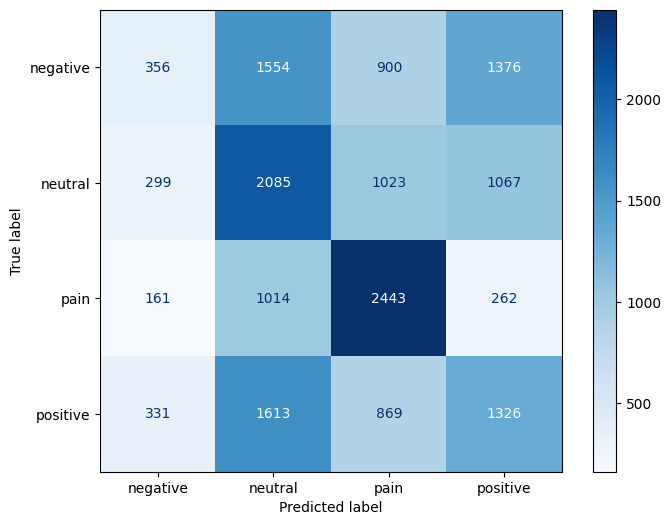

In [27]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

target_names = ['negative','neutral','pain','positive'];

# Predict
Y_pred = model.predict(test_dataset,verbose=1);
y_pred = np.argmax(Y_pred, axis=1);

# Calculate accuracy
categorical_accuracy = np.mean(test_dataset.classes == y_pred);
print(f'Categorical accuracy: {categorical_accuracy}');

# Confusion matrix
CM=confusion_matrix(test_dataset.classes, y_pred);

fname=os.path.join(output_dir,"confusion_matrix_enccls.eps");
fig, ax = plt.subplots(figsize=(8,6), dpi=100)
disp = ConfusionMatrixDisplay(confusion_matrix=CM, display_labels=target_names)
disp.plot(ax=ax,cmap=plt.cm.Blues)
plt.savefig(fname)

cm_dict=dict();
cm_dict['matrix']=CM.tolist();
cm_dict['label']=target_names;
# final all json
with open(os.path.join(output_dir,"confusion_matrix_enccls.json"), 'w') as f:
    json.dump(cm_dict, f,indent=4);
    f.close()

# Classification report
fname=os.path.join(output_dir,"classification_report_enccls.json")
dict_dat=classification_report(test_dataset.classes, y_pred, target_names=target_names,output_dict=True);
print(json.dumps(dict_dat, indent=4))
with open(fname, 'w') as f: 
    json.dump(dict_dat, f,indent=4);
    f.close()